In [7]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('../data/creditcard.csv')

# standard scale Amount
ss = StandardScaler()
df['normAmount'] = ss.fit_transform(pd.DataFrame(df['Amount']))

# drop Time and Amount
df.drop(columns = ['Time','Amount'], inplace = True)

X = df.drop(columns = 'Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# create SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())


In [3]:
# datset with stratify
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X, y, stratify = y, random_state = 42)


X_train_sm_sf, y_train_sm_sf = sm.fit_sample(X_train_sf, y_train_sf.ravel())

In [4]:
def plot_confusion_matrix(cm,title):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.xticks(ticks = [0,1],
               labels = ['predict normal','predict fraud'], 
               size = 12)
    plt.yticks(ticks = [0,1],
               labels = ['actual normal','actual fraud'], 
               size = 12)

    # cm.max() shows the larger value for class 0 and 1
    thresh = cm.max() / 2.
    
    # cm.shape = (2,2), i,j shows (0,0,1,1), (1,0,1,0)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # cm[i,j] only works with confusion_matrix without pd.DataFrame, it shows each data in matrix
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size =20)
    plt.xlabel('Predicted label', size = 20)
    plt.title(title, size = 30)

In [5]:
def feature_importance(model,df = X_train_sm):
    predictors = [x for x in df.columns]
    feat_imp = pd.Series(model.feature_importances_,predictors).sort_values(ascending = False)
    
    plt.figure(figsize = (8,6))
    feat_imp.plot(kind = 'bar')
    plt.ylabel('Feature Importance Score')
    plt.title('Feature Importance', size = 20);

In [21]:
def model_vis(model, index):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    cnf_train = confusion_matrix(y_train, prediction_train)
    cnf_test = confusion_matrix(y_test, prediction_test)
    
    recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
    recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])
    
    precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
    precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])
    
    roc_train = roc_auc_score(y_train, prediction_train)
    roc_test = roc_auc_score(y_test, prediction_test)

    result = {
        'false_positive_test' : cnf_test[0,1],
        'false_negative_test' : cnf_test[1,0],
        'recall_train' : recall_train, 
        'recall_test' : recall_test,
        'precision_train' : precision_train, 
        'precision_test' : precision_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
    }
    
    output = pd.DataFrame(result,index = [index])
    
    plot_train = plot_confusion_matrix(cnf_train,f'{index} train')
    plot_test = plot_confusion_matrix(cnf_test,f'{index} test')
    
#  feature_chart = feature_importance(model)
    
    return output

# VC: ET & Ada(ET)

In [13]:
estimator = [
    ('et',ExtraTreesClassifier(class_weight='balanced', random_state=42)),
    ('ada',AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=42),
                              learning_rate=1,
                              n_estimators=500, 
                              random_state=42))
]
vc1 = VotingClassifier(estimators=estimator,
                       n_jobs = 4)

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
VC1,4,7,0.957784,0.938053,0.98374,0.963636,0.978878,0.968998


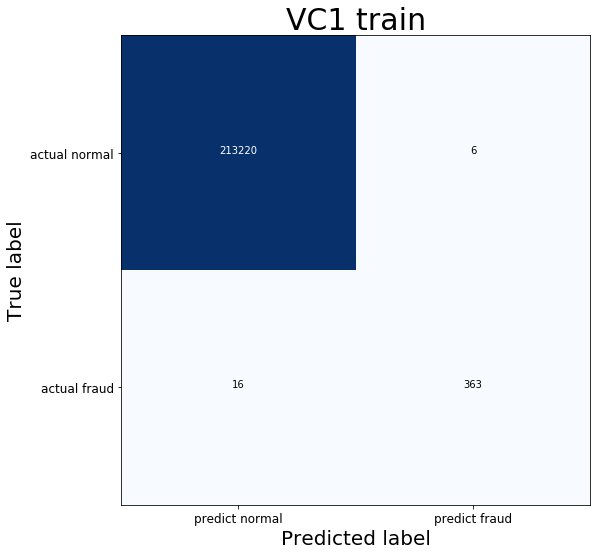

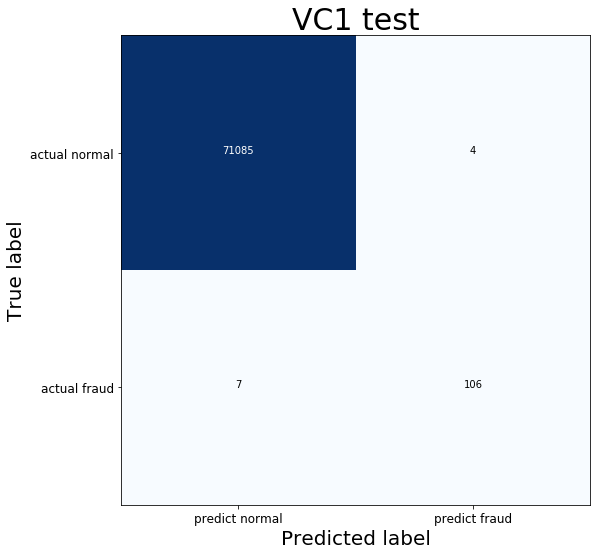

In [22]:
model = vc1.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'VC1')

# VC2: ET & RF

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
VC2,4,7,0.94723,0.938053,0.986264,0.963636,0.973603,0.968998


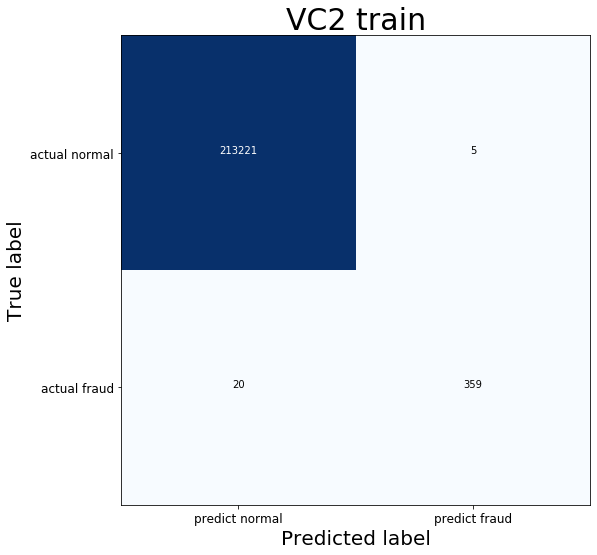

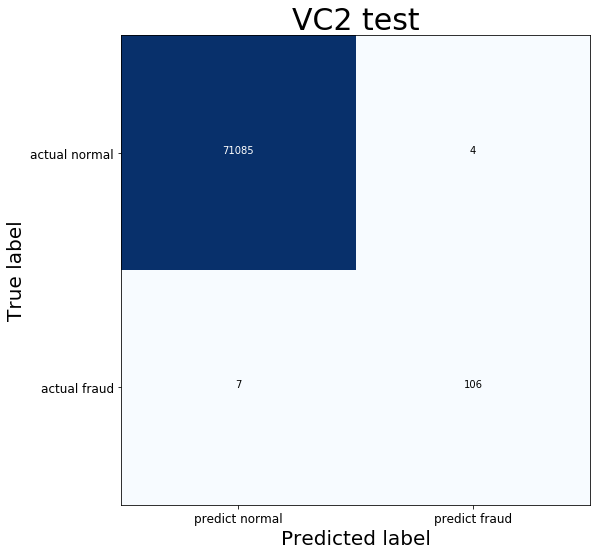

In [23]:
estimator = [
    ('et',ExtraTreesClassifier(class_weight='balanced', random_state=42)),
    ('rf',RandomForestClassifier(random_state=42))
]
vc2 = VotingClassifier(estimators=estimator,
                       n_jobs = 4)

model = vc2.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'VC2')

## VC function

In [25]:
def vc(estimator, title):
    vc = VotingClassifier(estimators = estimator, n_jobs = 4)
    model = vc.fit(X_train_sm_sf, y_train_sm_sf.ravel())
    model_vis(model,f'{title}')

# VC3: ET, XGB

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
VC3,4,8,0.957784,0.929204,0.989101,0.963303,0.978882,0.964574


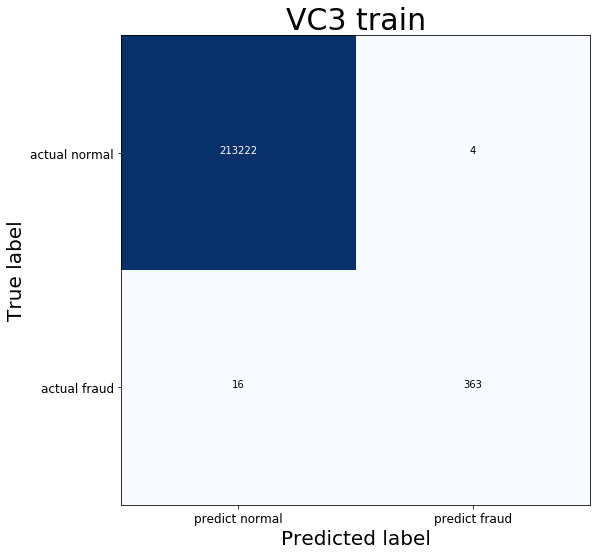

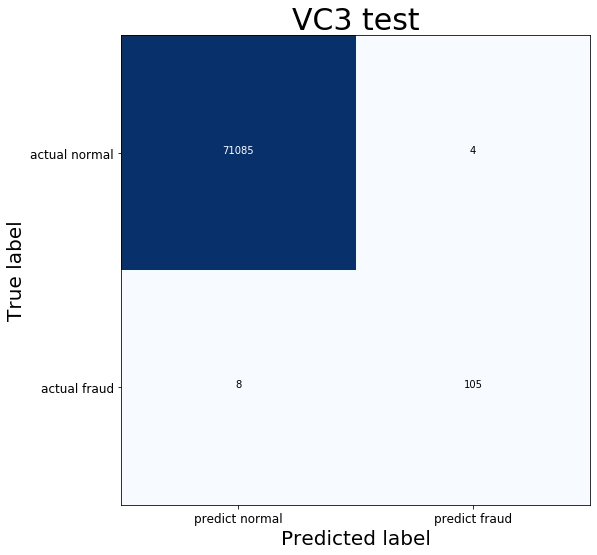

In [27]:
estimator = [
    ('et',ExtraTreesClassifier(class_weight='balanced', random_state=42)),
    ('xgb',XGBClassifier(learning_rate = 0.1, 
                         max_depth = 5, 
                         n_estimators=500, 
                         reg_alpha=0,
                         reg_lambda=0.5,
                         random_state=42))
]

vc3 = VotingClassifier(estimators=estimator,
                       n_jobs = 4)

model = vc3.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'VC3')

# VC4: ET & SVC

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
VC4,2,16,0.886544,0.858407,0.988235,0.979798,0.943262,0.929189


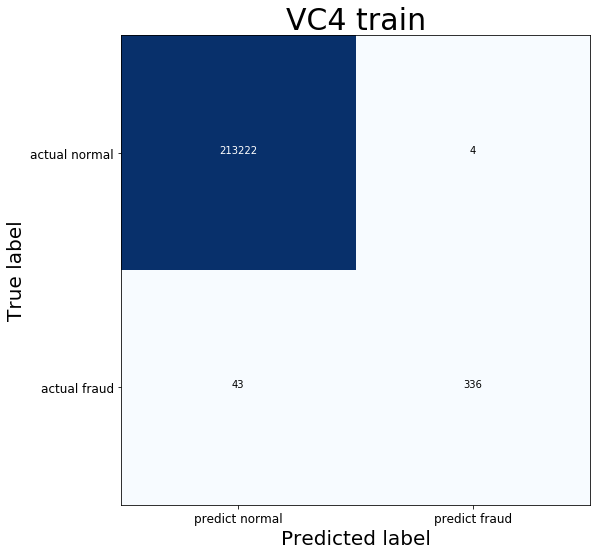

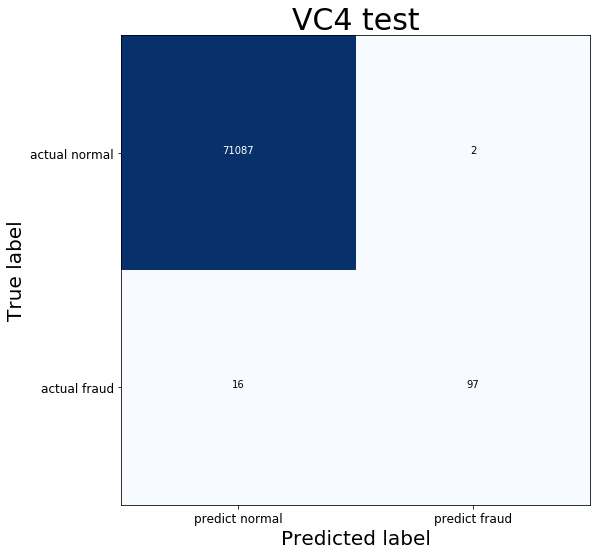

In [28]:
estimator = [
    ('et',ExtraTreesClassifier(class_weight='balanced', random_state=42)),
    ('svm',SVC(C = 1000, gamma = 'auto', random_state=42))
]

vc4 = VotingClassifier(estimators=estimator,
                       n_jobs = 4)

model = vc4.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'VC4')

# VC5: ET, Ada, RF

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
VC5,4,7,0.960422,0.938053,0.983784,0.963636,0.980197,0.968998


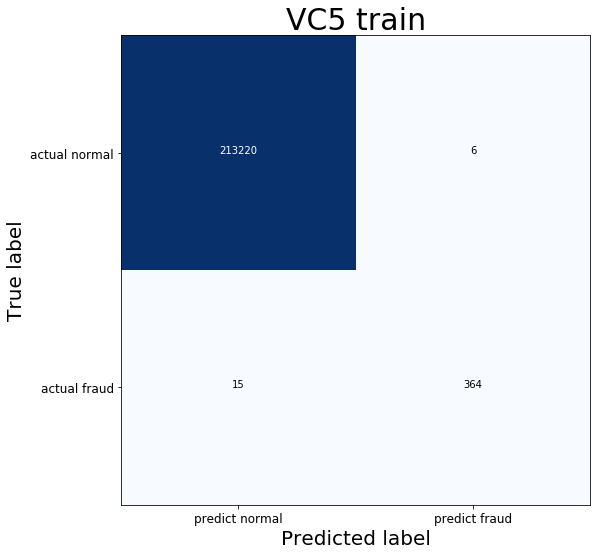

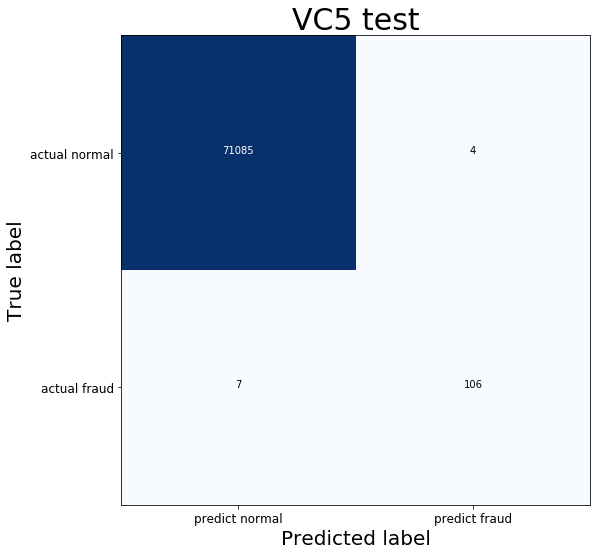

In [29]:
estimator = [
    ('et',ExtraTreesClassifier(class_weight='balanced', random_state=42)),
    ('ada',AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=42),
                              learning_rate=1,
                              n_estimators=500, 
                              random_state=42)),
    ('rf',RandomForestClassifier(random_state=42))
]
vc5 = VotingClassifier(estimators=estimator,
                       n_jobs = 4)
model = vc5.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'VC5')

# VC6

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
VC6,4,7,0.949868,0.938053,0.986301,0.963636,0.974922,0.968998


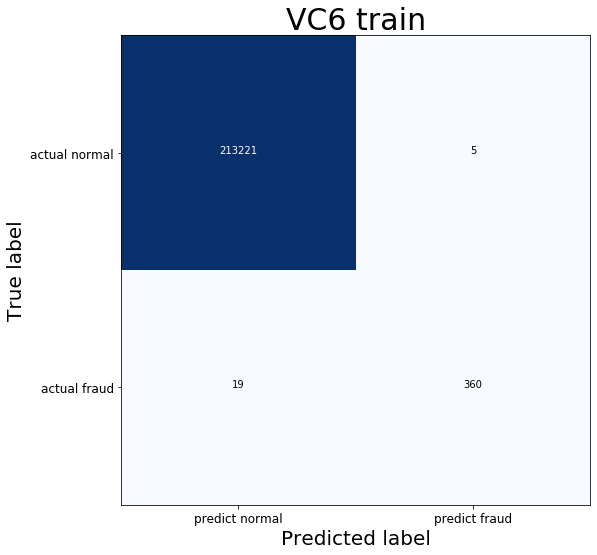

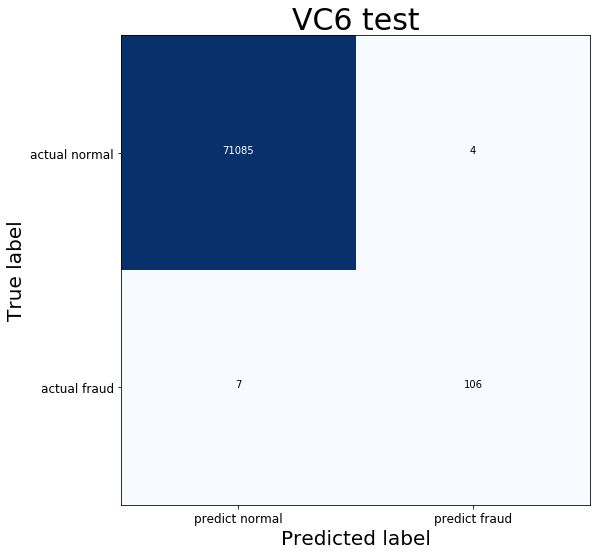

In [30]:
estimator = [
    ('et',ExtraTreesClassifier(class_weight='balanced', random_state=42)),
    ('ada',AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=42),
                              learning_rate=1,
                              n_estimators=500, 
                              random_state=42)),
    ('rf',RandomForestClassifier(random_state=42)),
    ('svm',SVC(C = 1000, gamma = 'auto', random_state=42))
]
vc6 = VotingClassifier(estimators=estimator,
                       n_jobs = 4)
model = vc6.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'VC6')